In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from variational_forms import _VariationalForm
from feature_maps import MediumFeatureMap
from pegasos_experiment import generate_qsvm_data, run_advanced_experiment
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from quantum_neural_networks import QuantumNeuralNetwork
from qiskit import BasicAer

In [69]:
# blue
color_0 = '#1f77b4'
color_0_light = '#8fbbd9'

# orange
color_1 = '#ff7f0e'
color_1_light = '#ffbf86'

colors = [color_0, color_1]
colors_light = [color_0_light,color_1_light]

# other constants
lower_percentile = 0.159
upper_percentile = 0.841

plt.rcParams.update({'font.size': 24,
                     'xtick.labelsize': 20,
                     'ytick.labelsize': 20,
                     'axes.titlesize': 28,
                     'axes.labelsize': 28,
                     'mathtext.fontset': 'stix',
                     'font.family': 'STIXGeneral'})

In [79]:
margin = 0.1
positive = 'positive' if margin > 0 else 'negative'
filename = f'data/advanced_margin_{margin}_data.csv'
# data size
M = 100
# iterations
N = 1000
# number of repeats per experiment
n = 50
shots = [4,8,16,32,64,128,256,512,1024,2048,4096]

In [80]:

Cs = [10.,1000.]

for C in Cs:
    run_advanced_experiment(margin,C,N,shots,M,0,n)
        

Approximating Kernels


11it [02:03, 11.20s/it]
  0%|          | 0/50 [00:00<?, ?it/s]/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
  2%|▏         | 1/50 [00:01<01:08,  1.39s/it]/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeW

Approximating Kernels


11it [02:01, 11.06s/it]
  0%|          | 0/50 [00:00<?, ?it/s]/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
  2%|▏         | 1/50 [00:01<01:11,  1.45s/it]/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeW

In [81]:
# load data
data = pd.read_csv(filename)
data = data[data['R'] > 1]

epsilons1 = []
epsilons2 = []
stops = []


for j, r in data.iterrows():
    file = f"data/dumps/{int(r['seed'])}_R_{int(r['R'])}_C_{r['C']}_M_{int(r['M'])}_margin_{margin}.pkl"
    history = pickle.load(open(file,'rb')) 
    hinges = history['hinge_loss'] 
    eps1 = history['epsilons']
    eps2 = history['epsilons2']


    #eps = np.array([np.max(np.abs(np.sum(y*(a[i] - a_state[-1])*K,axis=1))) for i in range(len(a_state))])

    diff = np.abs(hinges[1:] - hinges[:-1])
    stop = np.where(diff < 1e-4)[0][0]
    epsilons1.append(eps1)
    epsilons2.append(eps2)
    stops.append(stop)

stops = np.array(stops)
epsilons1 = np.array(epsilons1)
epsilons2 = np.array(epsilons2)

In [37]:
data.shape

(900, 8)

(50,)
(50,)


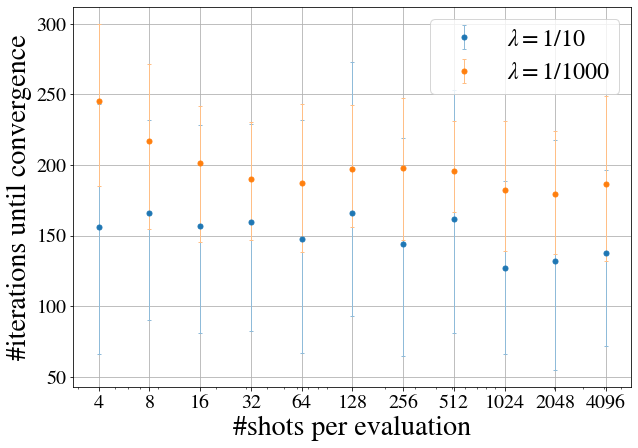

In [87]:
def plot_conv(C,c,cl):
    stops_R = np.array([stops[(data['R'] == R) & (data['C'] == C)] for R in shots])
    print((stops_R[0].shape))
    stop_means = np.mean(stops_R,axis=1)
    upper = np.quantile(stops_R, upper_percentile, axis=1)
    lower = np.quantile(stops_R,lower_percentile,axis=1)
    errors = np.array([stop_means - lower, upper - stop_means])
    #stop_std = np.std(stops_R,axis=1)
    plt.errorbar(shots,stop_means,yerr=errors,label=r'$\lambda = 1/{{%s}}$'%int(C),marker='.',ecolor=cl,elinewidth=1.,ls='',capsize=2,
        color=c, ms=10)

plt.figure(figsize=(10,7))
colors = [color_0, color_1]
colors_light = [color_0_light, color_1_light]
for i, C in enumerate(Cs):
    plot_conv(C,colors[i],colors_light[i])
plt.xscale('log')
plt.xticks(shots,shots)
plt.xlabel('#shots per evaluation')
plt.ylabel('#iterations until convergence')
plt.legend()
plt.grid()
plt.savefig(f'plots/convergence_{positive}_margin.png',dpi=200)


[-6.07785325 -5.50524859]
[-7.21362237 13.69636873]


Text(0.5, 0, 'Error $\\varepsilon$ after 500 iterations')

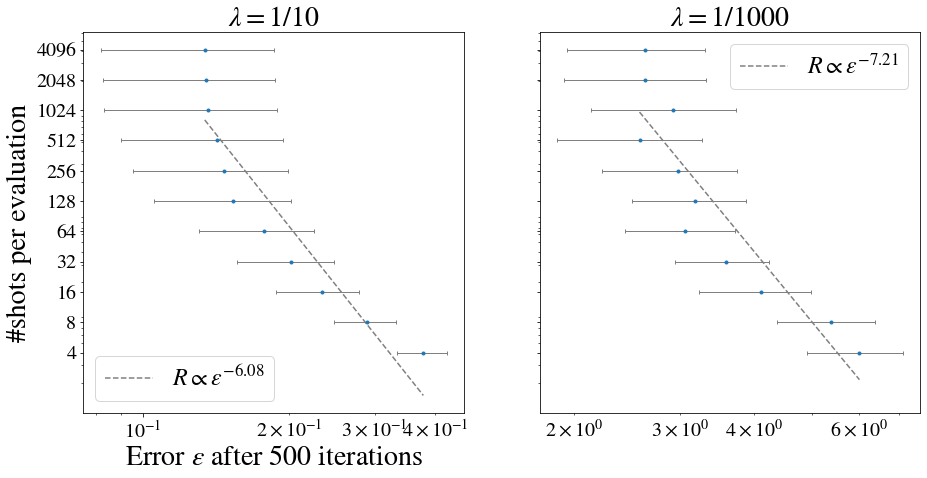

In [83]:
def plot_epsilon(C,stop_at,ax):
    filter = data['C'] == C
    epsC = np.array([epsilons2[:,stop_at][filter & (data['R'] == R)] for R in shots])
    eps_means = np.mean(epsC,axis=1)
    eps_std = np.std(epsC,axis=1)
    ax.errorbar(eps_means,shots,xerr=eps_std,marker='.',ecolor='grey',elinewidth=1.,ls='',capsize=2)
    p = np.polyfit(np.log(eps_means),np.log(shots),1)
    print(p)
    efine = np.linspace(np.min(eps_means),np.max(eps_means))
    ax.plot(efine,np.exp(p[1])*efine**p[0],'--',color='grey',label=r'$R\propto\varepsilon^{{%.2f}}$'%p[0])
    ax.set_title(r'$\lambda = 1/{{%s}}$'%int(C))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

fig, axs = plt.subplots(1,2,sharey=True,figsize=(15,7))
for i, C in enumerate(Cs):
    plot_epsilon(C,500,axs[i])

axs[0].set_yticks(shots,shots)
axs[0].set_ylabel('#shots per evaluation')
axs[0].set_xlabel(r'Error $\varepsilon$ after 500 iterations')


#plt.savefig(f'plots/exponent_{positive}_margin_500.png',dpi=200)


[-2.28400454 -1.34103881]
[-4.7771996   7.37125227]


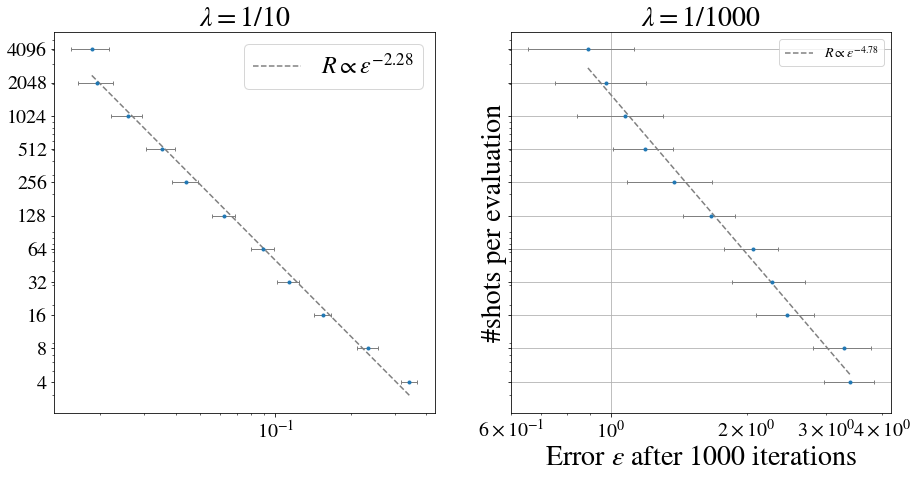

In [84]:
fig, axs = plt.subplots(1,2,sharey=True,figsize=(15,7))
for i, C in enumerate(Cs):
    plot_epsilon(C,-1,axs[i])

plt.yticks(shots,shots)
plt.ylabel('#shots per evaluation')
plt.xlabel(r'Error $\varepsilon$ after 1000 iterations')
plt.legend(fontsize=14)
plt.grid()

[-5.64980183 -1.18953319]
[-10.88383872  28.21662595]


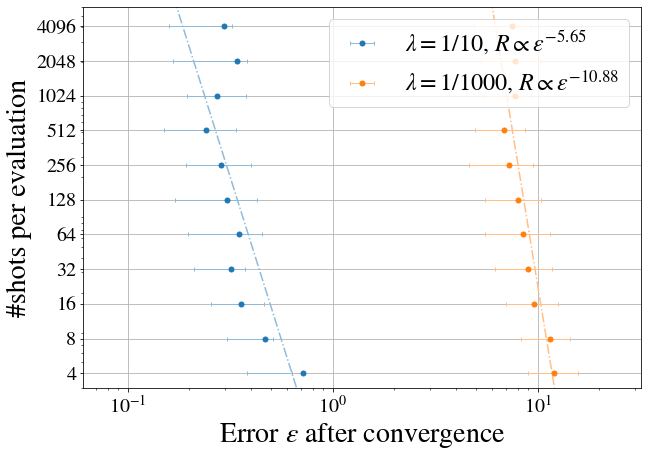

In [88]:
def plot_epsilon_convergence(C,c,cl):
    filter = data['C'] == C
    epsilons_conv = np.array([epsilons2[i,stops[i]] for i in range(len(epsilons2))])
    epsC = np.array([epsilons_conv[filter & (data['R'] == R)] for R in shots])
    eps_means = np.mean(epsC,axis=1)
    upper = np.quantile(epsC, upper_percentile, axis=1)
    lower = np.quantile(epsC,lower_percentile,axis=1)
    errors = np.array([eps_means - lower, upper - eps_means])
    #eps_std = np.std(epsC,axis=1)
    p = np.polyfit(np.log(eps_means),np.log(shots),1)
    print(p)
    plt.errorbar(eps_means,shots,xerr=errors,label=r'$\lambda=1/{{%s}},\, R\propto\varepsilon^{{%.2f}}$'%(int(C),p[0]),
        marker='.',ecolor=cl,elinewidth=1.,ls='',capsize=2, color=c, ms=10)
    efine = np.linspace(np.min(epsilons_conv),np.max(epsilons_conv))
    plt.plot(efine,np.exp(p[1])*efine**p[0],'-.',color=cl)


plt.figure(figsize=(10,7))
for i, C in enumerate(Cs):
    plot_epsilon_convergence(C,colors[i],colors_light[i])
plt.xscale('log')
plt.yscale('log')
plt.yticks(shots,shots)
plt.ylabel('#shots per evaluation')
plt.xlabel(r'Error $\varepsilon$ after convergence')
plt.legend(loc='upper right')
plt.ylim(3,6000)
plt.grid()
plt.savefig(f'plots/exponent_{positive}_margin_convergence.png',dpi=200)


2
0.09186145030176776
[-3.64299685  6.15777877]
1.5514157366403367
[-4.66026772 17.98322547]


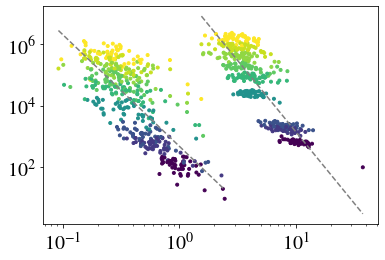

In [20]:
def plot_epsilon_convergence(C):
    filter = data['C'] == C
    epsilons_conv = np.array([epsilons2[i,stops[i]] for i in range(len(epsilons2))])[filter]
    total_shots = (stops*data['R'])[filter]
    colours = np.log(data['R'])[filter]
    plt.scatter(epsilons_conv,total_shots,marker='.',cmap='viridis',c=colours)
    print(min(epsilons_conv))
    p = np.polyfit(np.log(epsilons_conv),np.log(total_shots),1)
    print(p)
    efine = np.linspace(np.min(epsilons_conv),np.max(epsilons_conv))
    plt.plot(efine,np.exp(p[1])*efine**p[0],'--',color='grey',label=r'$R\propto\varepsilon^{{%.2f}}$'%p[0])

print(min(stops))
plt.yscale('log')
plt.xscale('log')
for C in Cs:
    plot_epsilon_convergence(C)
